# PANDAPROSUMER EXAMPLE: GAS BOILER WITH HEAT EXCHANGER

## DESCRIPTION:
This example describes how to create a single gas boiler element in pandaprosumer and connect it to a heat exchanger unit which is then connected to a single consumer (heat demand). The demand and source temperature data is read from an Excel file and stored in pandas dataframe. It includes the information about the power required by the consumer and source temperature at each time step.


![title](img/gb_hx.png)

## Glossary:
- Network: A configuration of connected energy generators and energy consumers
- Element: A single energy generator or a single energy consumer
- Controller: The logic of an element that defines its behaviour and its limits
- Prosumer/Container: A pandaprosumer data structure that holds data related to elements and their controllers.
- Const Profile Controller: The initial controller in the network that interacts with other element controllers; it also manages external data via time series.
- Map / mapping: A connection between two controllers that specifies what information is exchanged between the corresponding elements.

## Network design philosophy:
In pandaprosumer, a system's component is represented by a network element. Each element is assigned a container and its own element controller. A container is a structure that contains the component's configuration data (static input data), which can include information that will not change in the analysis such as size, nominal power, efficiency, etc. The behaviour of an element is governed by its controller. Connections between elements are defined in maps, which couple output parameters of one controller to the input parameter of a controller of a connected element. The network is managed by a controller called ConstProfileController. This controller is connected to all element controllers and manages dynamic input data from external sources (e.g. Excel file). For each time step it distributes the dynamic input data to the relevant element controllers.

# 1 - INPUT DATA:
First let's import libraries required for data management.

In [62]:
import pandas as pd
from pandapower.timeseries.data_sources.frame_data import DFData

Next we need to define properties of the heat exchanger which are treated as static input data, i.e. data (characteristics) that don't change during an analysis. In this case the properties for the heat exchanger are :

- `t_1_in_nom_c`:  Primary nominal input temperature [C]
- `t_1_out_nom_c`: Primary nominal output temperature [C]
- `t_2_in_nom_c`:Secondary nominal input temperature [C]
- `t_2_out_nom_c`:Secondary nominal output temperature [C]
- `mdot_2_nom_kg_per_s`:Secondary nominal mass flow [kg/s]


Next, we define the properties of the **gas boiler (gb)** :

- `max_q_kw`:  Maximal heat power of the boiler [kW]
- `name`: A label for the gas boiler.

 While these arguments are generally optional, in our specific case they are required in order to fully configure the heat exchanger. Other optional arguments are also available for more advanced configurations.

In [63]:
gb_params = {'max_q_kw': 500,
             'name':'gas_boiler'}


hx_params = {'t_1_in_nom_c': 72,
             't_1_out_nom_c': 47,
             't_2_in_nom_c': 32,
             't_2_out_nom_c': 63,
             'mdot_2_nom_kg_per_s': 2,
             'name':'heat_exchanger'}


hd_params = {"name": 'heat_consumer',
             "t_in_set_c": 76.5,
             "t_out_set_c": 20}

We define the analysis time series.

In [64]:
start = '2020-01-01 00:00:00'
end = '2020-01-01 23:59:59'
time_resolution_s = 900

Now we import our demand data and transform it into an appropriate DFData object. All data of an individual element is stored in a dedicated DFData object.

In [65]:
import sys
import os

current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
sys.path.append(parent_directory)

demand_data = pd.read_excel('data/hx_data.xlsx')

dur = pd.date_range(start=start, end=end, freq='900s',tz='utc')
demand_data.index = dur
demand_input = DFData(demand_data)
demand_input.df.head(10)


,demand_power
2020-01-01 00:00:00+00:00,0
2020-01-01 00:15:00+00:00,0
2020-01-01 00:30:00+00:00,0
2020-01-01 00:45:00+00:00,0
2020-01-01 01:00:00+00:00,0
2020-01-01 01:15:00+00:00,500
2020-01-01 01:30:00+00:00,500
2020-01-01 01:45:00+00:00,500
2020-01-01 02:00:00+00:00,321
2020-01-01 02:15:00+00:00,321


We can plot the evolution of the demand from the Excel file.

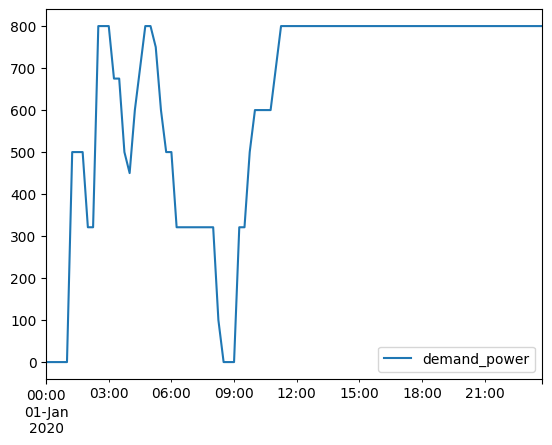

In [66]:
import matplotlib.pyplot as plt

demand_input.df.plot(y='demand_power')
plt.show()

# 2 - CREATING ELEMENTS OF THE NETWORK:
In this example, the network is made up of three elements: a source, storage and a consumer. The source is represented by a single heat pump, storage is defined by heat stratified storage element and the consumer is modelled by a single heat demand element.

We begin by defining an empty prosumer container object and then add the different elements and their respective controllers to it.

In [67]:
from pandaprosumer.create import create_empty_prosumer_container

prosumer = create_empty_prosumer_container()

Then we define the period of the analysis using input data about the analysis of time and also timezone and period name.

In [68]:
from pandaprosumer.create import create_period

period_id = create_period(prosumer, time_resolution_s, start, end, 'utc', 'default')

Now we can create the controllers connected to their respective containers and data. We also define the topology of the network by setting the elements' priority. In this example, the network has a linear configuration (the direction of energy flow goes in one direction), so only the order parameter is set:

- The const profile controller is always the first element in the network and is the only one that reads data from external sources (order 0, level 0),
- As the source, the gas boiler controller is the second element (order 0, level 1) in the network,
- Third element represents the heat exchanger(order 1, level 1),
 -The final order is the demand (order 2, level 1).

We begin by creating the Const Profile Controller.

In [69]:
from pandaprosumer.create_controlled import create_controlled_const_profile

cp_input_columns = ["demand_power"]
cp_result_columns = ["qdemand_kw"]
cp_controller_index = create_controlled_const_profile(prosumer, cp_input_columns, cp_result_columns, period_id, demand_input, level=0, order=0)

The heat exchanger, Gas Boiler and Heat demand controllers are now created

In [70]:
from pandaprosumer.create_controlled import create_controlled_heat_exchanger,create_controlled_gas_boiler,create_controlled_heat_demand

gb_controller_index = create_controlled_gas_boiler(prosumer, period=period_id, level=1, order=0, **gb_params)
hx_controller_index = create_controlled_heat_exchanger(prosumer, period=period_id, level=1, order=1, **hx_params)
hd_controller_index = create_controlled_heat_demand(prosumer, period=period_id, level=1, order = 2,**hd_params)

We can check that the elements were connected added to the prosumer with the specified parameters

In [71]:
prosumer.heat_exchanger

,name,t_1_in_nom_c,t_1_out_nom_c,t_2_in_nom_c,t_2_out_nom_c,mdot_2_nom_kg_per_s,delta_t_hot_default_c,max_q_kw,min_delta_t_1_c,primary_fluid,secondary_fluid,in_service
0,heat_exchanger,72.0,47.0,32.0,63.0,2.0,5.0,NaN,5.0,water,water,True


In [72]:
prosumer.gas_boiler

,name,max_q_kw,heating_value_kj_per_kg,efficiency_percent,in_service
0,gas_boiler,500.0,50000.0,100.0,True


In [73]:
prosumer.heat_demand

,name,scaling,in_service,t_in_set_c,t_out_set_c
0,heat_consumer,1.0,True,76.5,20.0


Additionnaly, we can check that for each element, a controller has been added to the prosumer

In [74]:
prosumer.controller

,object,in_service,order,level,initial_run,recycle
0,ConstProfileController,True,0,0,True,False
1,HeatExchangerController,True,1,1,True,False
2,GasBoilerController,True,0,1,True,False
3,HeatDemandController,True,2,1,True,False


# 4 - CREATING CONNECTIONS (MAPS) BETWEEN THE CONTROLLERS:
network configuration

For each controller we define how it is connected to other controllers.

In [75]:
from pandaprosumer.mapping import GenericMapping
from pandaprosumer.mapping import FluidMixMapping

CONNECTION CONST PROFILE CONTROLLER ---> HEAT DEMAND:

The connection from the Const Profile Controller to the Heat Demand Controller enables the heat demand to access the demand_power columns from the input time series dataset.

In [76]:
GenericMapping(prosumer,
               initiator_id=cp_controller_index,
               initiator_column=["qdemand_kw"],
               responder_id=hd_controller_index,
               responder_column=["q_demand_kw"],
               order=0)

CONNECTION GAS BOILER --->Heat exchanger:
The connection between the Heat Exchanger Controller and the Gas Boiler Controller allows the heat exchanger to read the gas boiler’s output and use it as an input for its own calculations. Instead of a generic mapping, a fluid mix mapping is used—this is necessary because the parameters being exchanged, such as mass flow, are dynamic and not static.

In [77]:
FluidMixMapping(prosumer,
                initiator_id=gb_controller_index,
                responder_id=hx_controller_index,
                order=0)

HEAT EXCHANGER ---> HEAT DEMAND:

In [78]:
FluidMixMapping(prosumer,
                initiator_id=hx_controller_index,
                responder_id=hd_controller_index,
                order=0)

5 - RUNNING THE ANALYSIS:
We can now run the analysis with the input data defined above.

In [79]:
from pandaprosumer.run_time_series import run_timeseries

run_timeseries(prosumer, period_id, verbose=True)

100%|██████████| 96/96 [00:05<00:00, 17.65it/s]


# 6 - PRINTING AND PLOTTING RESULTS:
All the results of the timeseries analysis are available in the prosumer.time_series dataframe

In [80]:
prosumer.time_series

,name,element,element_index,period_index,data_source
0,gas_boiler,gas_boiler,0.0,0.0,DFData
1,heat_exchanger,heat_exchanger,0.0,0.0,DFData
2,heat_consumer,heat_demand,0.0,0.0,DFData


Before plotting we have to look at the resulting dataframe to see which quantity (column) do we want to plot.

Access the results of the gas boiler:

In [81]:
prosumer.time_series.data_source.loc[0].df.head(10)

,q_kw,mdot_kg_per_s,t_in_c,t_out_c,mdot_gas_kg_per_s
2020-01-01 00:00:00+00:00,0.000000,0.000000,25.000000,25.0,0.000000
2020-01-01 00:15:00+00:00,0.000000,0.000000,25.000000,25.0,0.000000
2020-01-01 00:30:00+00:00,0.000000,0.000000,25.000000,25.0,0.000000
2020-01-01 00:45:00+00:00,0.000000,0.000000,25.000000,25.0,0.000000
2020-01-01 01:00:00+00:00,0.000000,0.000000,25.000000,25.0,0.000000
2020-01-01 01:15:00+00:00,468.737452,22.340350,76.500000,81.5,0.009375
2020-01-01 01:30:00+00:00,468.737452,22.340350,76.500000,81.5,0.009375
2020-01-01 01:45:00+00:00,468.737452,22.340350,76.500000,81.5,0.009375
2020-01-01 02:00:00+00:00,319.941495,1.628354,34.544748,81.5,0.006399
2020-01-01 02:15:00+00:00,319.941495,1.628354,34.544748,81.5,0.006399


Access the results of the heat_exchanger:

In [82]:
prosumer.time_series.data_source.loc[1].df.head(10)

,mdot_1_kg_per_s,t_1_in_c,t_1_out_c,mdot_2_kg_per_s,t_2_in_c,t_2_out_c
2020-01-01 00:00:00+00:00,0.000000,25.0,25.000000,0.000000,20.0,20.0
2020-01-01 00:15:00+00:00,0.000000,25.0,25.000000,0.000000,20.0,20.0
2020-01-01 00:30:00+00:00,0.000000,25.0,25.000000,0.000000,20.0,20.0
2020-01-01 00:45:00+00:00,0.000000,25.0,25.000000,0.000000,20.0,20.0
2020-01-01 01:00:00+00:00,0.000000,25.0,25.000000,0.000000,20.0,20.0
2020-01-01 01:15:00+00:00,22.340350,81.5,76.500000,1.984178,20.0,76.5
2020-01-01 01:30:00+00:00,22.340350,81.5,76.500000,1.984178,20.0,76.5
2020-01-01 01:45:00+00:00,22.340350,81.5,76.500000,1.984178,20.0,76.5
2020-01-01 02:00:00+00:00,1.628354,81.5,34.544748,1.358802,20.0,76.5
2020-01-01 02:15:00+00:00,1.628354,81.5,34.544748,1.358802,20.0,76.5


Access the results of the heat demand:

In [83]:
prosumer.time_series.data_source.loc[2].df.head(10)

,q_received_kw,q_uncovered_kw,mdot_kg_per_s,t_in_c,t_out_c
2020-01-01 00:00:00+00:00,0.000000,0.000000e+00,0.000000,20.0,20.0
2020-01-01 00:15:00+00:00,0.000000,0.000000e+00,0.000000,20.0,20.0
2020-01-01 00:30:00+00:00,0.000000,0.000000e+00,0.000000,20.0,20.0
2020-01-01 00:45:00+00:00,0.000000,0.000000e+00,0.000000,20.0,20.0
2020-01-01 01:00:00+00:00,0.000000,0.000000e+00,0.000000,20.0,20.0
2020-01-01 01:15:00+00:00,468.737452,3.126255e+01,1.984178,76.5,20.0
2020-01-01 01:30:00+00:00,468.737452,3.126255e+01,1.984178,76.5,20.0
2020-01-01 01:45:00+00:00,468.737452,3.126255e+01,1.984178,76.5,20.0
2020-01-01 02:00:00+00:00,321.000000,5.684342e-14,1.358802,76.5,20.0
2020-01-01 02:15:00+00:00,321.000000,5.684342e-14,1.358802,76.5,20.0


Alternatively, if the elements have unique names, we can change the indexing of the result dataframe to use the name of the elements as index and access the results more directly.

In [84]:
res_df = prosumer.time_series.copy()
res_df.set_index('name', inplace=True)

In [85]:
res_df

,element,element_index,period_index,data_source
name,,,,
gas_boiler,gas_boiler,0.0,0.0,DFData
heat_exchanger,heat_exchanger,0.0,0.0,DFData
heat_consumer,heat_demand,0.0,0.0,DFData


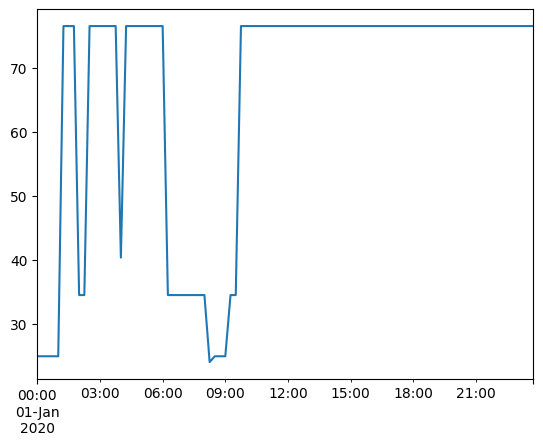

In [86]:
res_df.data_source.loc['heat_exchanger'].df.t_1_out_c.plot()
plt.show()

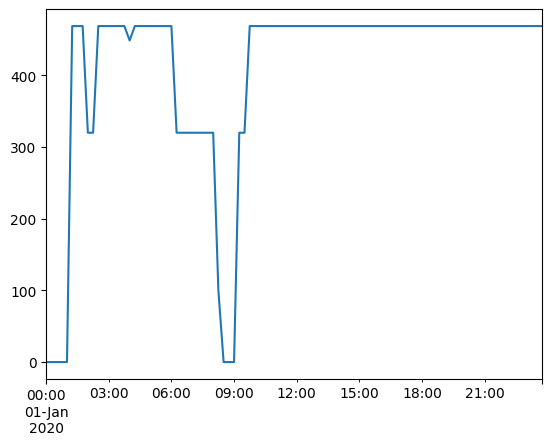

In [87]:
res_df.data_source.loc['gas_boiler'].df.q_kw.plot()
plt.show()

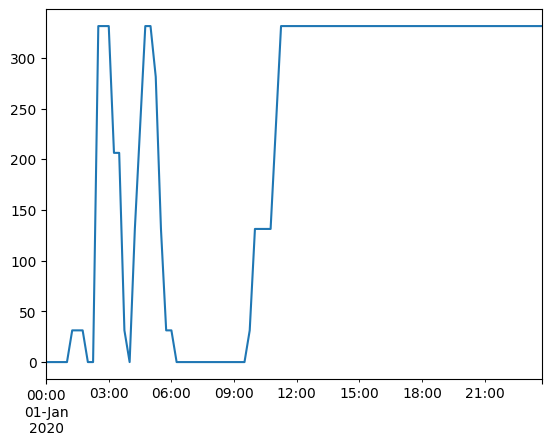

In [88]:
res_df.data_source.loc['heat_consumer'].df.q_uncovered_kw.plot()
plt.show()